# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 08/04/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.diffusion_model import *

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = int(config_hp["img_size"])
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = int(config_hp["batch_size"])
EPOCHS = int(config_hp["epochs"])
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


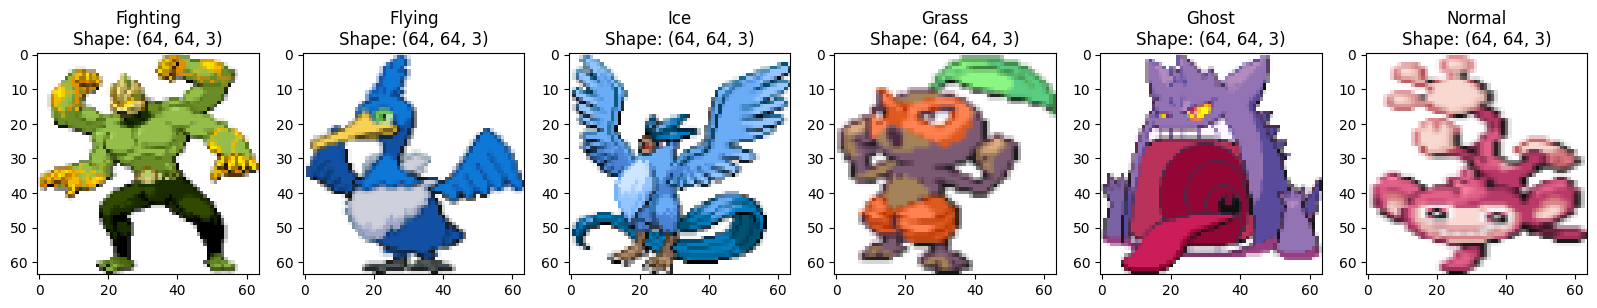

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1713216837.391594    1829 service.cc:145] XLA service 0x71df64002c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713216837.391637    1829 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1713216839.472802    2183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5201', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1713216839.531806    2180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5201', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1713216857.811274    1829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - loss: 0.4514
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.1368
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.1160
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.1066
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.1003
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0960
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0931
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0906
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0887
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0873
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0861
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0847
Epoch 13/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0838
Epoch 14/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0827
Epoch 15/100


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.11it/s]


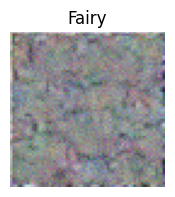

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 518ms/step - loss: 0.0779
Epoch 21/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0774
Epoch 22/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0767
Epoch 23/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0761
Epoch 24/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0754
Epoch 25/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0750
Epoch 26/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0745
Epoch 27/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0744
Epoch 28/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0737
Epoch 29/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0733
Epoch 30/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0729
Epoch 31/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0726
Epoch 32/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0719
Epoch 33/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0717
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.03it/s]


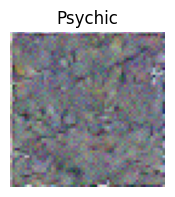

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 505ms/step - loss: 0.0696
Epoch 41/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0696
Epoch 42/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0692
Epoch 43/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0688
Epoch 44/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0686
Epoch 45/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0685
Epoch 46/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0684
Epoch 47/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0680
Epoch 48/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0679
Epoch 49/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0676
Epoch 50/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0672
Epoch 51/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0667
Epoch 52/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0665
Epoch 53/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0663
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.94it/s]


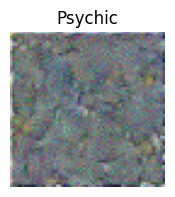

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0656
Epoch 61/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0653
Epoch 62/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0655
Epoch 63/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0653
Epoch 64/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0648
Epoch 65/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0648
Epoch 66/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0645
Epoch 67/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0640
Epoch 68/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0638
Epoch 69/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0636
Epoch 70/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0635
Epoch 71/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0633
Epoch 72/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0631
Epoch 73/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0631
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.54it/s]


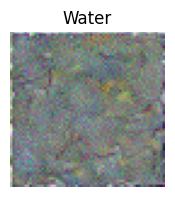

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0628
Epoch 81/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0625
Epoch 82/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0624
Epoch 83/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0622
Epoch 84/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0623
Epoch 85/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0622
Epoch 86/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0624
Epoch 87/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0622
Epoch 88/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0618
Epoch 89/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0614
Epoch 90/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0610
Epoch 91/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0609
Epoch 92/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0606
Epoch 93/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0605
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.73it/s]


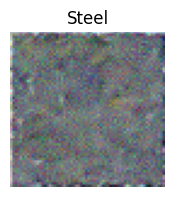

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - loss: 0.0601


In [6]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.92it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.08it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.68it/s]


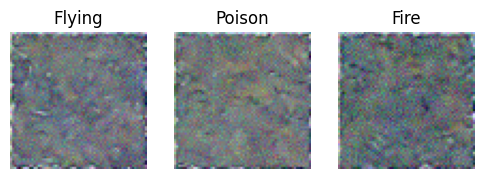

In [7]:
model.plot_samples(3)

In [ ]:
import gradio as gr

poke_diffusion = gr.Interface(
    fn=model.plot_samples,
    inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
    outputs=gr.Image(),
)

poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)